<a href="https://colab.research.google.com/github/xuxiufeng/Natural_Language_Processing_with_Disaster_Tweets/blob/main/Natural_Language_Processing_with_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I - Download Dataset

In [4]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle competitions download -c 'nlp-getting-started'

  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 52.2MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 29.0MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 65.0MB/s]


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip # download zip file

In [49]:
!unzip glove*.zip # unzip it

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


# II - Exploratory data analysis

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
import os

In [11]:
tweet = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
tweet.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [12]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

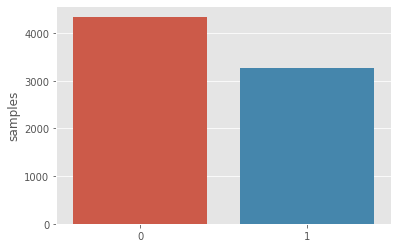

In [13]:
x = tweet.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples') # The gca() function in pyplot module of matplotlib library is used to get the current Axes instance on the current figure matching the given keyword args, or create one. 

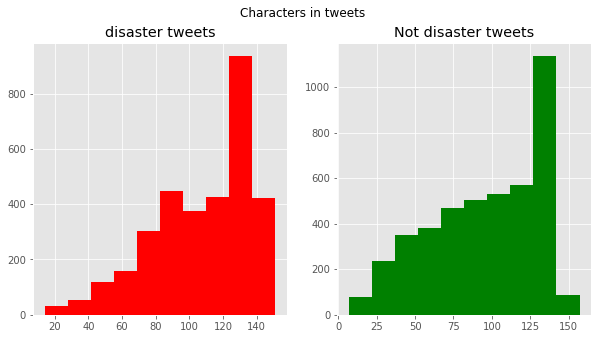

In [14]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

Number of words in a tweet

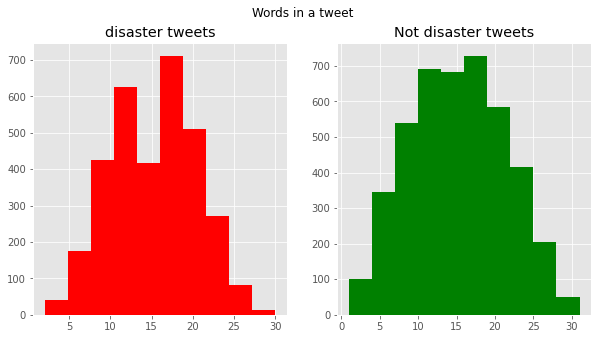

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Average word length in a tweet

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each tweet')

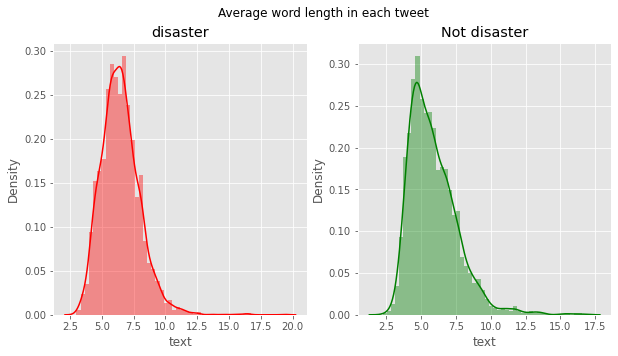

In [16]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [17]:
def create_corpus(target):
    corpus=[]  
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [18]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] + =1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

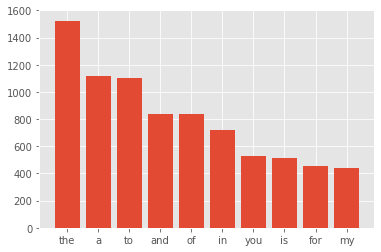

In [19]:
x,y = zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

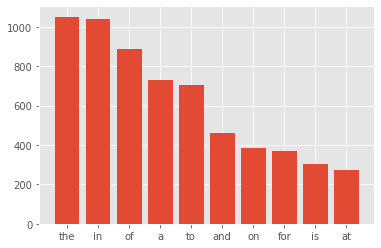

In [20]:
corpus = create_corpus(1)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y = zip(*top)
plt.bar(x,y)

<BarContainer object of 18 artists>

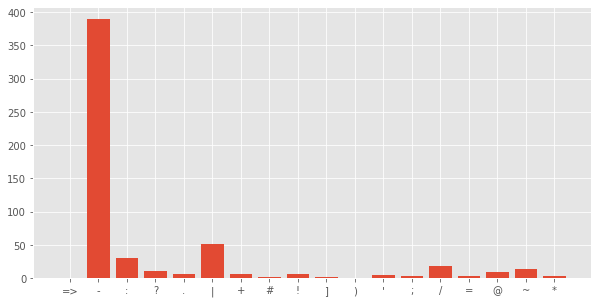

In [22]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic = defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i] += 1
        
x,y = zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

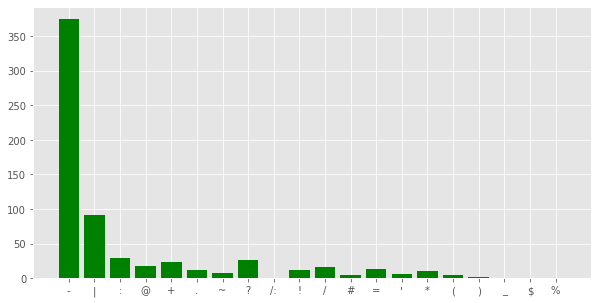

In [23]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic = defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i] += 1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

In [24]:
counter = Counter(corpus)
most = counter.most_common()
x = []
y = []
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

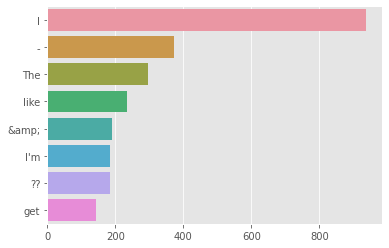

In [25]:
sns.barplot(x=y,y=x)

In [26]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

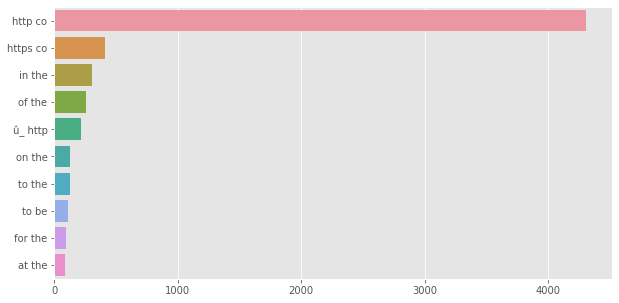

In [27]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [28]:
df = pd.concat([tweet,test])
df.shape

(10876, 5)

In [29]:
example = "New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [30]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [31]:
df['text'] = df['text'].apply(lambda x : remove_URL(x))

In [32]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [33]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [34]:
df['text'] = df['text'].apply(lambda x : remove_html(x))

In [35]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [36]:
df['text'] = df['text'].apply(lambda x: remove_emoji(x))

In [37]:
def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

example = "I am a #king"
print(remove_punct(example))

I am a king


In [38]:
df['text'] = df['text'].apply(lambda x : remove_punct(x))

In [39]:
!pip install pyspellchecker

     |████████████████████████████████| 2.7 MB 5.3 MB/s 


In [40]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

'correct me plese'

In [41]:
def create_corpus(df):
    corpus = []
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [43]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [44]:
corpus = create_corpus(df)

100%|██████████| 10876/10876 [00:01<00:00, 6962.36it/s]


Download zip file

In [50]:
embedding_dict = {}
with open('./glove.6B.100d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
f.close()

In [51]:
MAX_LEN=50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [52]:
word_index = tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [53]:
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 316749.26it/s]


In [56]:
model = Sequential()

embedding = Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer = Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           2034300   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 50, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


In [59]:
train = tweet_pad[:tweet.shape[0]]
test = tweet_pad[tweet.shape[0]:]

In [60]:
X_train,X_test,y_train,y_test = train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [61]:
history = model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
1618/1618 - 93s - loss: 0.6858 - accuracy: 0.5736 - val_loss: 0.6404 - val_accuracy: 0.6103 - 93s/epoch - 57ms/step
Epoch 2/15
1618/1618 - 87s - loss: 0.5713 - accuracy: 0.7331 - val_loss: 0.5164 - val_accuracy: 0.7662 - 87s/epoch - 54ms/step
Epoch 3/15
1618/1618 - 85s - loss: 0.5377 - accuracy: 0.7527 - val_loss: 0.5011 - val_accuracy: 0.7741 - 85s/epoch - 53ms/step
Epoch 4/15
1618/1618 - 85s - loss: 0.5268 - accuracy: 0.7583 - val_loss: 0.4907 - val_accuracy: 0.7828 - 85s/epoch - 53ms/step
Epoch 5/15
1618/1618 - 86s - loss: 0.5163 - accuracy: 0.7633 - val_loss: 0.4848 - val_accuracy: 0.7846 - 86s/epoch - 53ms/step
Epoch 6/15
1618/1618 - 85s - loss: 0.5081 - accuracy: 0.7685 - val_loss: 0.4771 - val_accuracy: 0.7890 - 85s/epoch - 53ms/step
Epoch 7/15
1618/1618 - 90s - loss: 0.5002 - accuracy: 0.7758 - val_loss: 0.4717 - val_accuracy: 0.7933 - 90s/epoch - 56ms/step
Epoch 8/15
1618/1618 - 86s - loss: 0.4967 - accuracy: 0.7750 - val_loss: 0.4719 - val_accuracy: 0.7960 - 86s/ep

In [62]:
sample_sub = pd.read_csv('./sample_submission.csv')

In [63]:
y_pre = model.predict(test)
y_pre = np.round(y_pre).astype(int).reshape(3263)
sub = pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

In [64]:
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
